Inicialmente, el usuario dibuja un rectángulo alrededor de la región de primer plano (la región de primer plano debe estar completamente dentro del rectángulo). Luego, el algoritmo lo segmenta iterativamente para obtener el mejor resultado. Hecho. Pero en algunos casos, la segmentación no estará bien, es decir, puede haber marcado alguna región de primer plano como fondo y viceversa. En ese caso, el usuario deberá realizar finos retoques. Simplemente dé algunos trazos a las imágenes donde se encuentren algunos resultados defectuosos. Strokes básicamente dice *"Oye, esta región debe estar en primer plano, la marcaste como fondo, corrígela en la siguiente iteración"* o su opuesto para el fondo. Luego, en la siguiente iteración, obtendrá mejores resultados.

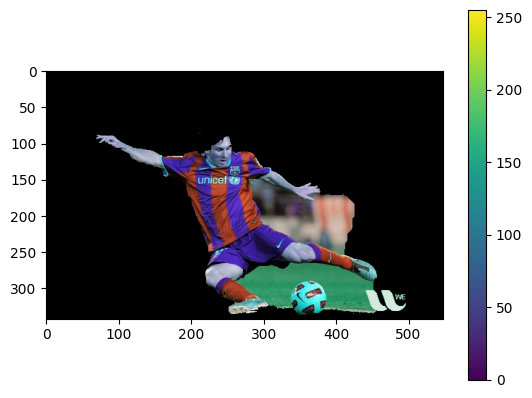

(<matplotlib.image.AxesImage at 0x7fba06c3c280>,
 None)

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('resources/messi5.jpg')
assert img is not None, "file could not be read, check with os.path.exists()"
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (50,50,450,290)
cv.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
plt.imshow(img),plt.colorbar(),plt.show()

Ahora optamos por el algoritmo grabcut con OpenCV. OpenCV tiene la función cv.grabCut() para esto. Veremos primero sus argumentos:

img - Imagen de entrada
máscara : es una imagen de máscara donde especificamos qué áreas son fondo, primer plano o probable fondo/primer plano, etc. Se realiza mediante las siguientes banderas, cv.GC_BGD , cv.GC_FGD , cv.GC_PR_BGD , cv.GC_PR_FGD , o simplemente pasar 0,1,2,3 a la imagen.
rect : son las coordenadas de un rectángulo que incluye el objeto de primer plano en el formato (x,y,w,h)
bdgModel , fgdModel : son matrices utilizadas internamente por el algoritmo. Simplemente crea dos matrices cero de tipo np.float64 de tamaño (1,65).
iterCount : número de iteraciones que debe ejecutar el algoritmo.
modo : debe ser cv.GC_INIT_WITH_RECT o cv.GC_INIT_WITH_MASK o combinado, lo que decide si estamos dibujando un rectángulo o trazos de retoque finales.

Primero veamos con el modo rectangular. Cargamos la imagen, creamos una imagen de máscara similar. Creamos fgdModel y bgdModel . Le damos los parámetros del rectángulo. Todo es sencillo. Deje que el algoritmo se ejecute durante 5 iteraciones. El modo debe ser cv.GC_INIT_WITH_RECT ya que estamos usando un rectángulo. Luego ejecuta el grabcut. Modifica la imagen de la máscara. En la nueva imagen de máscara, los píxeles se marcarán con cuatro banderas que indican el fondo/primer plano como se especifica arriba. Entonces modificamos la máscara de modo que todos los píxeles de 0 y 2 píxeles se pongan en 0 (es decir, el fondo) y todos los píxeles de 1 y 3 píxeles se pongan en 1 (es decir, los píxeles de primer plano). Ahora nuestra máscara final está lista. Simplemente multiplíquelo con la imagen de entrada para obtener la imagen segmentada.

In [3]:
# newmask is the mask image I manually labelled
newmask = cv.imread('resources/pic1.png', cv.IMREAD_GRAYSCALE)
assert newmask is not None, "file could not be read, check with os.path.exists()"
# wherever it is marked white (sure foreground), change mask=1
# wherever it is marked black (sure background), change mask=0
mask[newmask == 0] = 0
mask[newmask == 255] = 1
mask, bgdModel, fgdModel = cv.grabCut(img,mask,None,bgdModel,fgdModel,5,cv.GC_INIT_WITH_MASK)
mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask[:,:,np.newaxis]
plt.imshow(img),plt.colorbar(),plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 342 but corresponding boolean dimension is 300

Exercises

1

In [ ]:
from __future__ import print_function

import numpy as np
import cv2 as cv

import sys

class App():
    BLUE = [255,0,0]        # rectangle color
    RED = [0,0,255]         # PR BG
    GREEN = [0,255,0]       # PR FG
    BLACK = [0,0,0]         # sure BG
    WHITE = [255,255,255]   # sure FG

    DRAW_BG = {'color' : BLACK, 'val' : 0}
    DRAW_FG = {'color' : WHITE, 'val' : 1}
    DRAW_PR_BG = {'color' : RED, 'val' : 2}
    DRAW_PR_FG = {'color' : GREEN, 'val' : 3}

    # setting up flags
    rect = (0,0,1,1)
    drawing = False         # flag for drawing curves
    rectangle = False       # flag for drawing rect
    rect_over = False       # flag to check if rect drawn
    rect_or_mask = 100      # flag for selecting rect or mask mode
    value = DRAW_FG         # drawing initialized to FG
    thickness = 3           # brush thickness

    def onmouse(self, event, x, y, flags, param):
        # Draw Rectangle
        if event == cv.EVENT_RBUTTONDOWN:
            self.rectangle = True
            self.ix, self.iy = x,y

        elif event == cv.EVENT_MOUSEMOVE:
            if self.rectangle == True:
                self.img = self.img2.copy()
                cv.rectangle(self.img, (self.ix, self.iy), (x, y), self.BLUE, 2)
                self.rect = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.rect_or_mask = 0

        elif event == cv.EVENT_RBUTTONUP:
            self.rectangle = False
            self.rect_over = True
            cv.rectangle(self.img, (self.ix, self.iy), (x, y), self.BLUE, 2)
            self.rect = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.rect_or_mask = 0
            print(" Now press the key 'n' a few times until no further change \n")

        # draw touchup curves

        if event == cv.EVENT_LBUTTONDOWN:
            if self.rect_over == False:
                print("first draw rectangle \n")
            else:
                self.drawing = True
                cv.circle(self.img, (x,y), self.thickness, self.value['color'], -1)
                cv.circle(self.mask, (x,y), self.thickness, self.value['val'], -1)

        elif event == cv.EVENT_MOUSEMOVE:
            if self.drawing == True:
                cv.circle(self.img, (x, y), self.thickness, self.value['color'], -1)
                cv.circle(self.mask, (x, y), self.thickness, self.value['val'], -1)

        elif event == cv.EVENT_LBUTTONUP:
            if self.drawing == True:
                self.drawing = False
                cv.circle(self.img, (x, y), self.thickness, self.value['color'], -1)
                cv.circle(self.mask, (x, y), self.thickness, self.value['val'], -1)

    def run(self):
        # Loading images
        if len(sys.argv) == 2:
            filename = sys.argv[1] # for drawing purposes
        else:
            print("No input image given, so loading default image, lena.jpg \n")
            print("Correct Usage: python grabcut.py <filename> \n")
            filename = 'lena.jpg'

        self.img = cv.imread(cv.samples.findFile(filename))
        self.img2 = self.img.copy()                               # a copy of original image
        self.mask = np.zeros(self.img.shape[:2], dtype = np.uint8) # mask initialized to PR_BG
        self.output = np.zeros(self.img.shape, np.uint8)           # output image to be shown

        # input and output windows
        cv.namedWindow('output')
        cv.namedWindow('input')
        cv.setMouseCallback('input', self.onmouse)
        cv.moveWindow('input', self.img.shape[1]+10,90)

        print(" Instructions: \n")
        print(" Draw a rectangle around the object using right mouse button \n")

        while(1):

            cv.imshow('output', self.output)
            cv.imshow('input', self.img)
            k = cv.waitKey(1)

            # key bindings
            if k == 27:         # esc to exit
                break
            elif k == ord('0'): # BG drawing
                print(" mark background regions with left mouse button \n")
                self.value = self.DRAW_BG
            elif k == ord('1'): # FG drawing
                print(" mark foreground regions with left mouse button \n")
                self.value = self.DRAW_FG
            elif k == ord('2'): # PR_BG drawing
                self.value = self.DRAW_PR_BG
            elif k == ord('3'): # PR_FG drawing
                self.value = self.DRAW_PR_FG
            elif k == ord('s'): # save image
                bar = np.zeros((self.img.shape[0], 5, 3), np.uint8)
                res = np.hstack((self.img2, bar, self.img, bar, self.output))
                cv.imwrite('grabcut_output.png', res)
                print(" Result saved as image \n")
            elif k == ord('r'): # reset everything
                print("resetting \n")
                self.rect = (0,0,1,1)
                self.drawing = False
                self.rectangle = False
                self.rect_or_mask = 100
                self.rect_over = False
                self.value = self.DRAW_FG
                self.img = self.img2.copy()
                self.mask = np.zeros(self.img.shape[:2], dtype = np.uint8) # mask initialized to PR_BG
                self.output = np.zeros(self.img.shape, np.uint8)           # output image to be shown
            elif k == ord('n'): # segment the image
                print(""" For finer touchups, mark foreground and background after pressing keys 0-3
                and again press 'n' \n""")
                try:
                    bgdmodel = np.zeros((1, 65), np.float64)
                    fgdmodel = np.zeros((1, 65), np.float64)
                    if (self.rect_or_mask == 0):         # grabcut with rect
                        cv.grabCut(self.img2, self.mask, self.rect, bgdmodel, fgdmodel, 1, cv.GC_INIT_WITH_RECT)
                        self.rect_or_mask = 1
                    elif (self.rect_or_mask == 1):       # grabcut with mask
                        cv.grabCut(self.img2, self.mask, self.rect, bgdmodel, fgdmodel, 1, cv.GC_INIT_WITH_MASK)
                except:
                    import traceback
                    traceback.print_exc()

            mask2 = np.where((self.mask==1) + (self.mask==3), 255, 0).astype('uint8')
            self.output = cv.bitwise_and(self.img2, self.img2, mask=mask2)

        print('Done')


if __name__ == '__main__':
    print(__doc__)
    App().run()
    cv.destroyAllWindows()